# HMM on Open Street Map

# References

In [1]:
# I acknowledge that this work is my own, and I have used ChatGPT 4 (OpenAI, https://chat.openai.com/) to
# rectify few of my errors in the code and also in some places where I had doubts in the code that I have explicitly mentioned in the codes below.
# I also incorporated suggestions and materials provided by my supervisor as specified. 

In [2]:
# Codes Adapted from:

# M. Tipping, “Example of using the OSMNX library to optimise routes around Bath”, Apr 2024, Python code, University of Bath, Unpublished

# https://osmnx.readthedocs.io/en/stable/user-reference.html
# https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.graph.graph_from_place
# https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.plot.plot_graph_route
# Boeing, G. 2017. OSMnx: New Methods for Acquiring, Constructing, Analyzing, and Visualizing Complex Street Networks. Computers, Environment and Urban Systems 65, 126-139.

# Forward Pass - 
#  AzharuddinKazi, Forward-Algorithm-HMM [computer program], 
#  Available from: https://github.com/AzharuddinKazi/Forward-Algorithm-HMM/blob/master/Forward_Algorithm_HMM.py

# Baum-Welch-Algorithm -  
#  A Developer Diary, Abhisek Jana, Derivation and implementation of Baum Welch Algorithm for Hidden Markov Model [computer program], 
#  Available from: https://www.adeveloperdiary.com/data-science/machine-learning/derivation-and-implementation-of-baum-welch-algorithm-for-hidden-markov-model/

# Viterbi Agorithm - 
#  Pierian Training, Viterbi Algorithm Implementation in Python: A Practical Guide [computer program], 
#  Available from: https://pieriantraining.com/viterbi-algorithm-implementation-in-python-a-practical-guide/#:~:text=It%20is%20used%20for%20finding,apply%20it%20to%20our%20problem.


# Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx  # Possibly not needed
import osmnx as ox
import osmnx.routing
print(ox.__version__)  # 1.9.2 at time of coding

1.9.2


# Loading and processing map data 

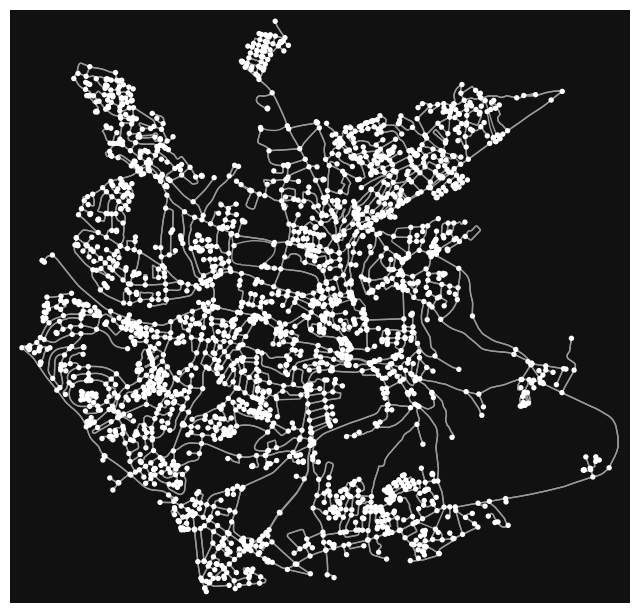

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [2]:
# download/model a street network for some city then visualize it
# Code given by Supervisor
#G = ox.graph_from_place("Bath, UK", network_type="bike")
#G = ox.graph_from_place("Bath, UK", network_type="walk")
G = ox.graph_from_place("Bath, UK", network_type="drive")
ox.plot_graph(G)

Graph based on roads within 0.5 miles of Laura Place contains 400 nodes.


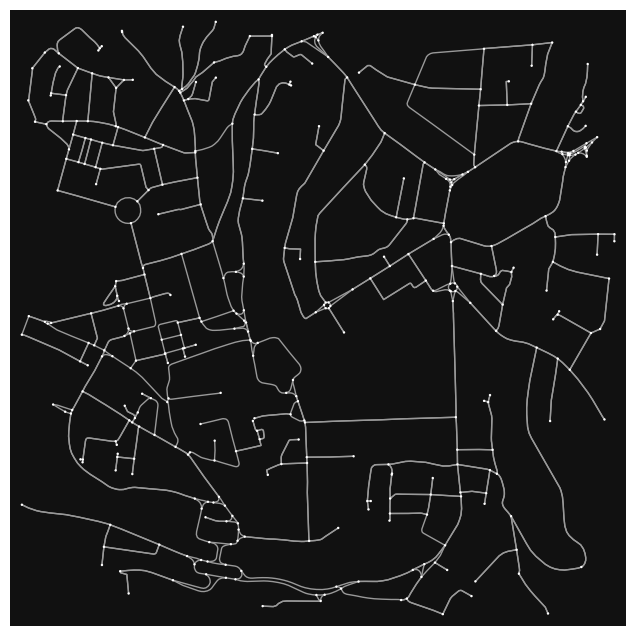

In [3]:
# download/model a street network for some city then visualize it
# Code given by Supervisor
location = "Laura Place"
one_mile = 1609  # meters
miles = 1/2
#G = ox.graph_from_address("BA2 4BL", dist=int(one_mile * miles), network_type="bike")
#G = ox.graph_from_address("BA2 4BL", dist=int(one_mile * miles), network_type="walk")
G = ox.graph_from_address("BA2 4BL", dist=int(one_mile * miles), network_type="drive")
N = len(G)
print(f"Graph based on roads within {miles} miles of {location} contains {N} nodes.")
fig, ax = ox.plot_graph(G, node_size=3)

In [4]:
# Code given by Supervisor
G = ox.routing.add_edge_speeds(G)
G = ox.routing.add_edge_travel_times(G)
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

In [5]:
gdf_nodes 

,y,x,street_count,highway,geometry
osmid,,,,,
126719,51.377429,-2.360963,3,NaN,POINT (-2.36096 51.37743)
126983,51.378321,-2.364749,3,NaN,POINT (-2.36475 51.37832)
126985,51.377465,-2.361213,3,NaN,POINT (-2.36121 51.37747)
246631,51.378808,-2.368185,3,NaN,POINT (-2.36819 51.37881)
257157,51.381022,-2.366279,3,NaN,POINT (-2.36628 51.38102)
...,...,...,...,...,...
11156263441,51.387437,-2.366354,3,NaN,POINT (-2.36635 51.38744)
11175680258,51.378538,-2.359996,3,NaN,POINT (-2.36000 51.37854)
11670095329,51.380363,-2.360685,1,NaN,POINT (-2.36068 51.38036)


In [6]:
gdf_edges.head()

osmid  oneway   lanes   ref  \
u      v         key                                                          
126719 905000573 0    [35486466, 37777462, 127635974]    True  [1, 2]  A367   
       333986    0                           55290796    True       1   A36   
126983 333702    0                               2520   False     NaN   NaN   
       380033    0                          133875223   False       2   A36   
       246631    0                          133875223   False       2   A36   

                          highway maxspeed reversed   length bridge  \
u      v         key                                                  
126719 905000573 0        primary   30 mph    False   85.035    yes   
       333986    0          trunk   30 mph    False   49.841    NaN   
126983 333702    0    residential      NaN     True   62.105    NaN   
       380033    0          trunk   30 mph    False  142.825    NaN   
       246631    0          trunk   30 mph     True  245.715    NaN   

                                                               geometry  \
u      v         key                                                      
126719 905000573 0    LINESTRING (-2.36096 51.37743, -2.36083 51.377...   
       333986    0    LINESTRING (-2.36096 51.37743, -2.36077 51.377...   
126983 333702    0    LINESTRING (-2.36475 51.37832, -2.36484 51.378...   
       380033    0    LINESTRING (-2.36475 51.37832, -2.36431 51.378...   
       246631    0    LINESTRING (-2.36475 51.37832, -2.36488 51.378...   

                      speed_kph  travel_time    junction                name  \
u      v         key                                                           
126719 905000573 0         48.3          6.3         NaN                 NaN   
       333986    0         48.3          3.7  roundabout                 NaN   
126983 333702    0         32.2          6.9         NaN          Oak Street   
       380033    0         48.3         10.6         NaN  Lower Bristol Road   
       246631    0         48.3         18.3         NaN  Lower Bristol Road   

                     width tunnel access  
u      v         key                      
126719 905000573 0     NaN    NaN    NaN  
       333986    0     NaN    NaN    NaN  
126983 333702    0     NaN    NaN    NaN  
       380033    0     NaN    NaN    NaN  
       246631    0     NaN    NaN    NaN

400


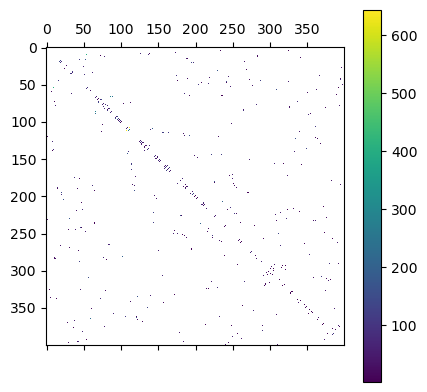

In [7]:
# Code given by Supervisor
index = gdf_nodes.index
N = len(gdf_nodes)
print(N)
DIST = np.full((N, N), fill_value=np.nan)
#
index_from = gdf_edges.index.get_level_values('u')
index_to = gdf_edges.index.get_level_values('v')
for i in range(N):
    id_i = gdf_nodes.index[i]
    for j in range(N):
        id_j = gdf_nodes.index[j]
        if (id_i, id_j, 0) in gdf_edges.index:
            length = gdf_edges.loc[(id_i, id_j, 0), "length"]
            DIST[i, j] = length

plt.matshow(DIST)
plt.colorbar()
pass

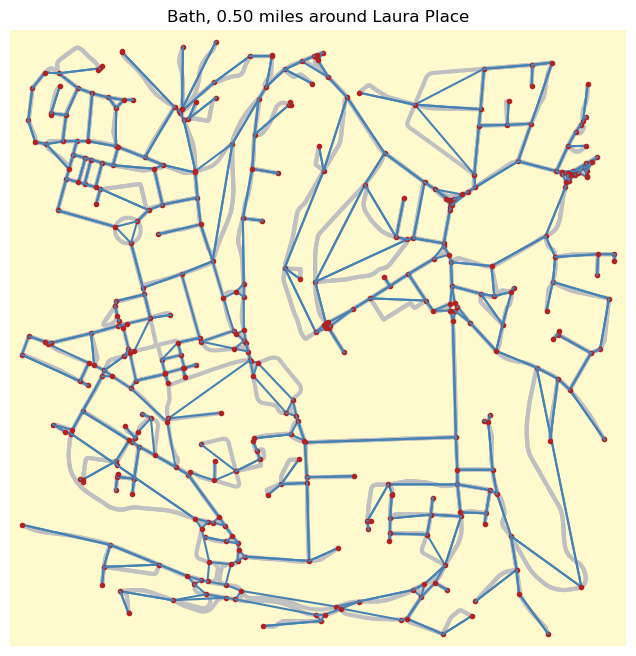

In [8]:
# Code given by Supervisor
fig, ax = ox.plot_graph(G, bgcolor="LemonChiffon", node_color="orange", node_size=3,
                        edge_color="silver", edge_linewidth=3, close=False, show=False)
#
x = gdf_nodes.x.values
y = gdf_nodes.y.values
#ax.plot(x[3], y[3], "r*", ms=20, zorder=2)
#ax.plot(x[200], y[200], "g*", ms=20, zorder=2)

for i in range(N):
    for j in range(N):
        if not np.isnan(DIST[i, j]):
            ax.plot((x[i], x[j]), (y[i], y[j]), '-', color="SteelBlue")
    ax.plot(x[i], y[i], '.', color="Firebrick")
#
ax.set_title(f"Bath, {miles:.2f} miles around {location}")
pass



# Finding Index of each Node 

Text(0.5, 1.0, 'Bath, 0.50 miles around Laura Place')

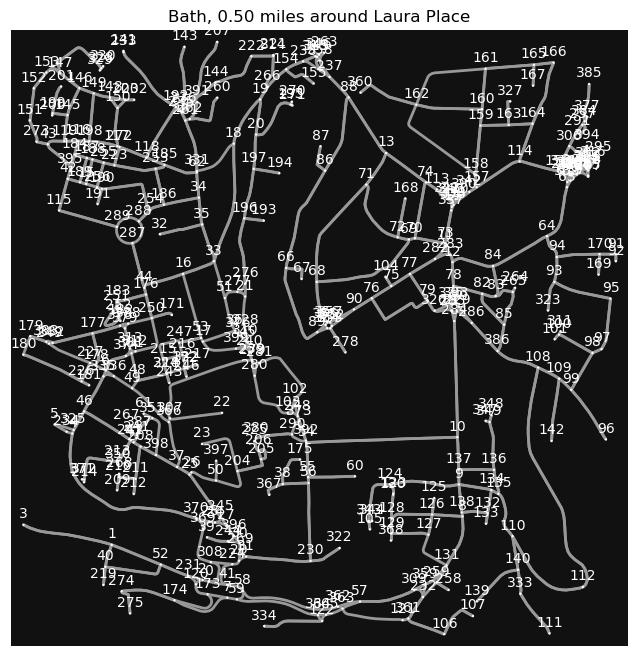

In [9]:
fig, ax = ox.plot_graph(G, node_size=3, edge_linewidth=2, close=False, show=False)

x = gdf_nodes.x.values
y = gdf_nodes.y.values

# Annotate all nodes with their index 
# https://www.geeksforgeeks.org/matplotlib-axes-axes-annotate-in-python/
for i, (node, data) in enumerate(gdf_nodes.iterrows()):
    ax.annotate(i, (x[i], y[i]), textcoords="offset points", xytext=(0,5), ha='center', color='white')

ax.set_title(f"Bath, {miles:.2f} miles around {location}")


Distance Matrix and Transition Probabilities:
DIST is a matrix that represents distances between nodes. 
Entries with NaN values are treated as infinite distances (implying no direct path between those nodes).
The inverse_dist matrix is created by taking the reciprocal of DIST 
to handle proximity calculations, which is then normalized to derive transition probabilities (A). - asked GPT


In [59]:
# Convert NaNs in DIST to a large number (infinity)
DIST = np.nan_to_num(DIST, nan=np.inf)

# Inverse distance for proximity calculation, avoiding infinity and zero distances - asked GPT
epsilon = 0.01  # Small constant to prevent division issues
inverse_dist = np.where(DIST != np.inf, 1.0 / (DIST + epsilon), 0)

# Normalize rows of the inverse distance matrix to get transition probabilities
row_sums = inverse_dist.sum(axis=1, keepdims=True)

row_sums[row_sums == 0] = np.inf #  avoid division by zero

A = inverse_dist / row_sums

In [11]:
start_node_index = 111
end_state_index = 115

# Emission probabilities (uniform)
b = np.full(N, 1/N) 
b[end_state_index] = 1

pi = np.zeros(N)
pi[start_node_index] = 1

In [12]:
class HMM_Forward_Backward:
    
    def forward_pass(self,A, pi, b,T):
        """ Forward pass algorithm for HMM.
    
        A: Transition matrix.
        pi: Initial state distribution.
        b: Emission probability (cost of each vector).
        T: Number of steps in the model.
        Returns: Alpha matrix containing forward probabilities and “likelihood” of the “observations”.
        """
        N = A.shape[0]  # Number of states
        
        alpha = np.zeros((N, T))
        
        epsilon = 1e-10  # Small constant to prevent log(0)
        scaling_factors = np.zeros(T)  # Initialize scaling factors

        # Initialize alpha values at step 0
        alpha[:, 0] = pi * b

        # Compute alpha values for each time step
        for t in range(1,T):
            for j in range(N):
                alpha[j, t] = np.sum(alpha[:, t-1] * A[:, j]) * b[j]
                
            scaling_factors[t] = np.sum(alpha[:, t]) 
            alpha[:, t] /= scaling_factors[t]  # Scale alpha values 

        # Compute log likelihood
        log_likelihood = np.sum(np.log(scaling_factors + epsilon))

        return alpha, log_likelihood

    def backward_pass(self,A, b,T):
        """
         Backward pass algorithm for HMM.
    
         Parameters:
         A: Transition matrix.
         b: Emission probability (cost of each vector).
         T: Number of steps in the model.
         Returns: Beta matrix containing backward probabilities.
        """
        N = A.shape[0]
       
        epsilon = 1e-10  # Small constant to prevent log(0)
        
        beta = np.zeros((N, T))

        # Initialization
        beta[:, T-1] = 1

        # Compute beta values for each time step
        for t in range(T-2, -1, -1):
            for i in range(N):
                beta[i, t] = np.sum(A[i, :] * b[i] * beta[:, t+1])
                
            beta[:, t] /= np.sum(beta[:, t+1]) + epsilon  # Scale beta values

        return beta

    def compute_gamma(self,alpha, beta, A, T):
        """
        Compute the gamma matrix for a Hidden Markov Model.
    
        alpha:  Alpha matrix from the forward pass.
        beta: Beta matrix from the backward pass.

        Returns: Gamma matrix containing the probability of being in each state at each time step.
        """
        N = A.shape[0]  
      
        gamma = np.zeros((N, T))

        for t in range(T):
            denominator = np.sum(alpha[:, t] * beta[:, t])
            for i in range(N):
                numerator = alpha[i, t] * beta[i, t]
                
                gamma[i, t] = numerator / denominator

        return gamma

    def compute_xi(self,alpha, beta, A, b,T):
        """
        Compute the Xi matrix for a Hidden Markov Model.

        alpha: Alpha matrix from the forward pass.
        beta: Beta matrix from the backward pass.
        A: Transition matrix.
        b: Emission probability vector.
        T: Total number of time steps.

        Returns: Xi matrix containing the joint probability of transitions between states at each time step.
        """
        N = A.shape[0]
       
        xi = np.zeros((N, N, T-1))

        for t in range(T-1):  
            denominator = np.sum(alpha[:, t] * A * b * beta[:, t+1])
            for i in range(N):
                numerator = alpha[i, t] * A[i, :] * b * beta[:, t+1] 
                                        
                xi[i, :, t] = numerator / denominator

        return xi


    def update_transition_matrix(self,xi, gamma, T):
        """
        Update the transition matrix A using xi and gamma.

        Parameters:
        xi: Xi matrix containing the joint probability of transitions between states at each time step.
        gamma: Gamma matrix containing the probability of being in each state at each time step.

        Returns: Updated transition matrix A.
        """
        N = xi.shape[0]
        
        A_updated = np.zeros((N, N))

        for i in range(N):
            denominator = np.sum(gamma[i, :T-1]) 
            for j in range(N):
                numerator = np.sum(xi[i, j, :T-1])  
                
                if denominator == 0 or denominator == np.nan:
                    A_updated[i, j] = 0  # Avoid division by zero
                
                A_updated[i, j] = numerator / denominator
                
        # Normalize to ensure rows of A sum to 1
        A_updated /= np.sum(A_updated, axis=1, keepdims=True)
 
        return A_updated

   # Viterbi Algorithm 
    def viterbi_algorithm(self, A, pi, b,T,end_state,max_repeats=1):
        """
        Viterbi algorithm for finding the most likely sequence of hidden states.
        
        Returns: Most likely sequence of states.
        """
        N = A.shape[0]
        viterbi = np.zeros((N, T))
        backpointer = np.zeros((N, T), dtype=int)
        

        # Initialize
        viterbi[:, 0] = pi * b
        backpointer[:, 0] = 0

        end_state_count = 0  # Counter for repetitions of end_state

        # Recursion step
        for t in range(1, T):
            for s in range(N):
                transition_probs = viterbi[:, t-1] * A[:, s]
                max_prob = np.max(transition_probs)
                best_prev_state = np.argmax(transition_probs)
                viterbi[s, t] = max_prob * b[s]
                backpointer[s, t] = best_prev_state

        # Check if current state is repeatedly the end_state
            current_best = np.argmax(viterbi[:, t])
            if current_best == end_state:
                end_state_count += 1
            else:
                end_state_count = 0  

            # Early termination 
            if end_state_count >= max_repeats:
                T = t + 1  
                break

         # Termination step
        best_last_state = np.argmax(viterbi[:, T-1])
        best_path_prob = viterbi[best_last_state, T-1]

        # Path reconstruction
        best_path = [best_last_state]
        for t in range(T-1, 0, -1):
            best_path.insert(0, backpointer[best_path[0], t])

        return best_path



[-290.82551189 -244.78976056 -244.71017661 -244.71002216 -244.71002177
 -244.71002177 -244.71002177 -244.71002177 -244.71002177 -219.68329185]


Text(0, 0.5, 'Log Probability')

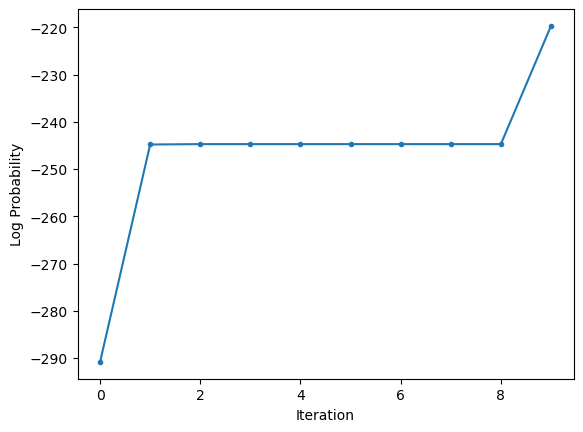

In [59]:
T = 50
num_its = 10
# Initialize the HMM class
# Code from Supervisor
fb = HMM_Forward_Backward()
likelihood_it = np.empty(num_its)

for it in range(num_its):
    
    # Calculate forward and backward passes with scaling
    alpha_values, log_likelihood = fb.forward_pass(A, pi, b,T)
    likelihood_it[it] = log_likelihood
    beta_values = fb.backward_pass(A, b,T)

    # Compute gamma and xi
    gamma = fb.compute_gamma(alpha_values, beta_values, A,T)
    xi = fb.compute_xi(alpha_values, beta_values, A, b,T)

    # Update the transition matrix
    A_new = fb.update_transition_matrix(xi, gamma,T)
    A = A_new

print(likelihood_it)
plt.plot(likelihood_it, '.-')
plt.xlabel("Iteration")
plt.ylabel("Log Probability")


# Finding Route between two points

**Multiple routes - Drive**

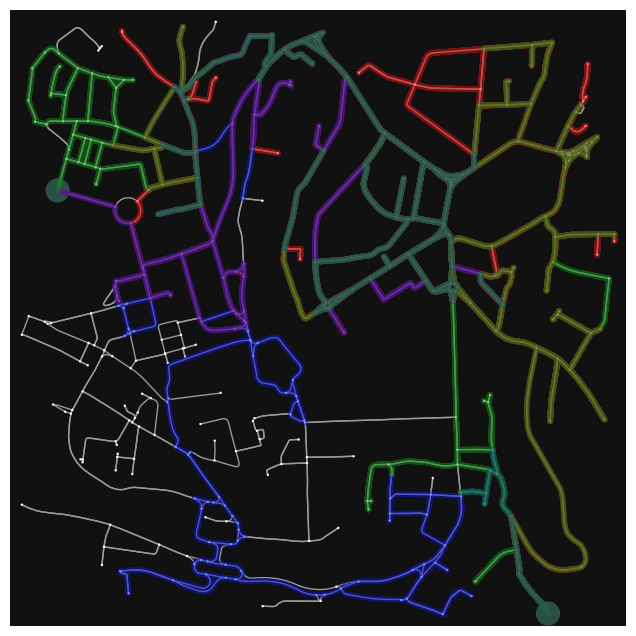

In [54]:
# 3 paths 
num_paths = 3
all_paths_indices = []
start_node_index = 111
end_state_index = 115

T = 10

# Simulate multiple paths 
for path_number in range(num_paths):
    current_state = start_node_index
    path_indices = [current_state]
    
    while current_state != end_state_index:
        next_state = np.random.choice(range(N), p=A[current_state])
        path_indices.append(next_state)
        current_state = next_state

    all_paths_indices.append(path_indices)

# Convert the path indices to OSM IDs for visualization
all_paths_osmids = []
for path_indices in all_paths_indices:
    path_osmids = gdf_nodes.iloc[path_indices].index.tolist()
    all_paths_osmids.append(path_osmids)

# Plot the graph with the new routes
colors = ['#e61010', '#0d17d4', '#0e8f15']
fig, ax = ox.plot_graph_routes(G, all_paths_osmids, route_colors= colors, route_linewidth=6, node_size=3, orig_dest_size= 300)
plt.show()

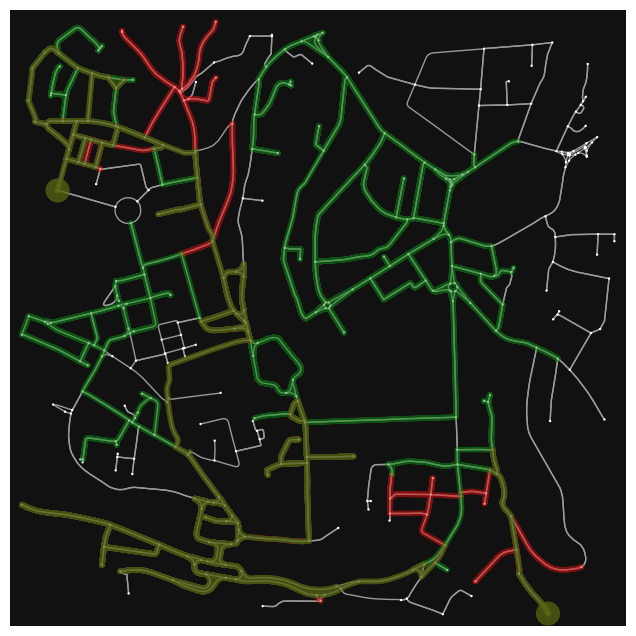

In [61]:
# 2 paths 
num_paths = 2
all_paths_indices = []
start_node_index = 111
end_state_index = 115

T = 10

# Simulate multiple paths 
for path_number in range(num_paths):
    current_state = start_node_index
    path_indices = [current_state]
    
    while current_state != end_state_index:
        next_state = np.random.choice(range(N), p=A[current_state])
        path_indices.append(next_state)
        current_state = next_state

    all_paths_indices.append(path_indices)

# Convert the path indices to OSM IDs for visualization
all_paths_osmids = []
for path_indices in all_paths_indices:
    path_osmids = gdf_nodes.iloc[path_indices].index.tolist()
    all_paths_osmids.append(path_osmids)

# Plot the graph with the new routes
colors = ['#e61010', '#0e8f15']
fig, ax = ox.plot_graph_routes(G, all_paths_osmids, route_colors= colors, route_linewidth=6, node_size=3, orig_dest_size=300)
plt.show()

**Route 1 - Walking**

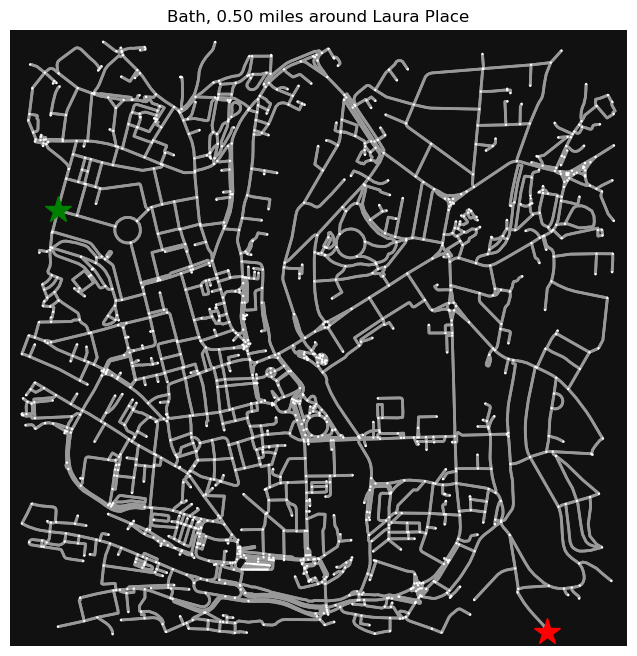

In [110]:
# Code given by Supervisor
fig, ax = ox.plot_graph(G, node_size=3, edge_linewidth=2, close=False, show=False)
#
x = gdf_nodes.x.values
y = gdf_nodes.y.values
ax.plot(x[158], y[158], "r*", ms=20, zorder=2)
#ax.plot(x[635], y[635], "g*", ms=20, zorder=2)
ax.plot(x[162], y[162], "g*", ms=20, zorder=2)

ax.set_title(f"Bath, {miles:.2f} miles around {location}")
pass

In [111]:
start_node_index = 158
end_state_index = 162

# Emission probabilities (uniform)
b = np.full(N, 1/N) 
b[end_state_index] = 1

pi = np.zeros(N)
pi[start_node_index] = 1

In [18]:
T = 100
# Initialize the HMM class
fb = HMM_Forward_Backward()

In [113]:
best_path_indices = fb.viterbi_algorithm(A, pi, b, T, end_state_index)

In [114]:
path_osmids = gdf_nodes.iloc[best_path_indices].index.tolist()

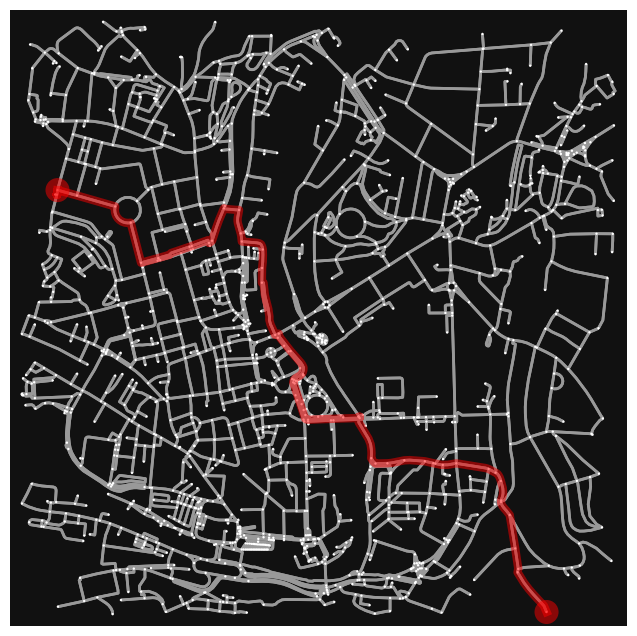

In [115]:
fig, ax = ox.plot_graph_route(G, path_osmids, route_color='red', route_linewidth=6, edge_linewidth=2, node_size=3, orig_dest_size=300)

plt.show()

**Route 1 - Driving** 

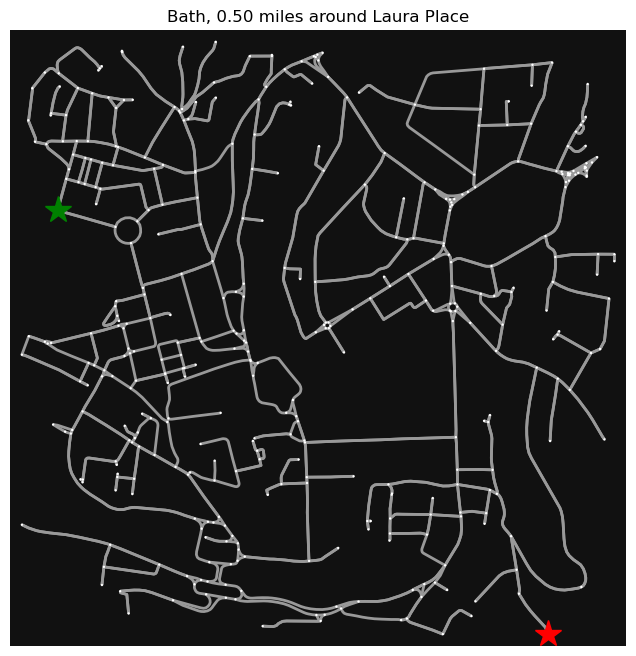

In [12]:
# Code given by Supervisor
fig, ax = ox.plot_graph(G, node_size=3, edge_linewidth=2, close=False, show=False)
#
x = gdf_nodes.x.values
y = gdf_nodes.y.values
ax.plot(x[111], y[111], "r*", ms=20, zorder=2)
ax.plot(x[115], y[115], "g*", ms=20, zorder=2)

ax.set_title(f"Bath, {miles:.2f} miles around {location}")
pass


In [13]:
start_node_index = 111
end_state_index = 115

# Emission probabilities (uniform)
b = np.full(N, 1/N) 
b[end_state_index] = 1

pi = np.zeros(N)
pi[start_node_index] = 1

In [14]:
T = 100
# Initialize the HMM class
fb = HMM_Forward_Backward()

In [15]:
best_path_indices = fb.viterbi_algorithm(A, pi, b, T, end_state_index)

In [16]:
path_osmids = gdf_nodes.iloc[best_path_indices].index.tolist()

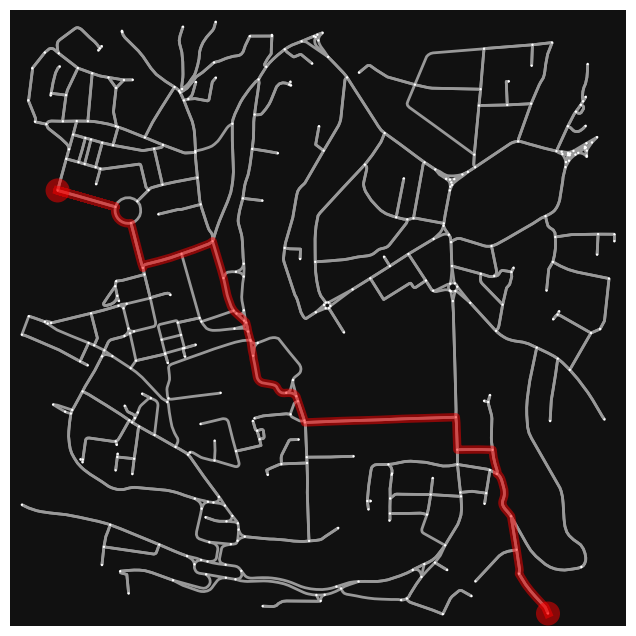

In [17]:
fig, ax = ox.plot_graph_route(G, path_osmids, route_color='red', route_linewidth=6, edge_linewidth=2, node_size=3, orig_dest_size=300)

plt.show()

**Route 2 - Driving** 

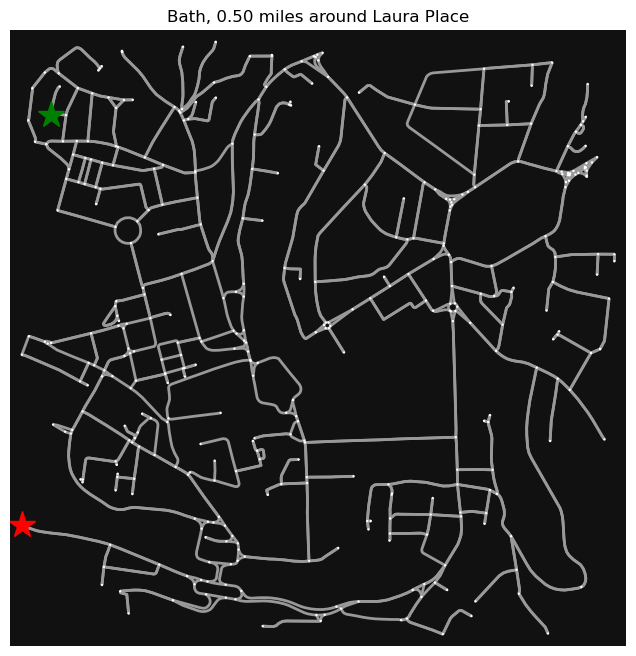

In [18]:
# Code given by Supervisor
fig, ax = ox.plot_graph(G, node_size=3, edge_linewidth=2, close=False, show=False)
#
x = gdf_nodes.x.values
y = gdf_nodes.y.values
ax.plot(x[3], y[3], "r*", ms=20, zorder=2)
ax.plot(x[200], y[200], "g*", ms=20, zorder=2)

ax.set_title(f"Bath, {miles:.2f} miles around {location}")
pass

In [87]:
start_node_index = 3
end_state_index = 200

# Emission probabilities (uniform)
b = np.full(N, 1/N) 
b[end_state_index] = 1

pi = np.zeros(N)
pi[start_node_index] = 1

In [20]:
T = 100
# Initialize the HMM class
fb = HMM_Forward_Backward()

In [88]:
best_path_indices = fb.viterbi_algorithm(A, pi, b, T, end_state_index)

In [89]:
path_osmids = gdf_nodes.iloc[best_path_indices].index.tolist()

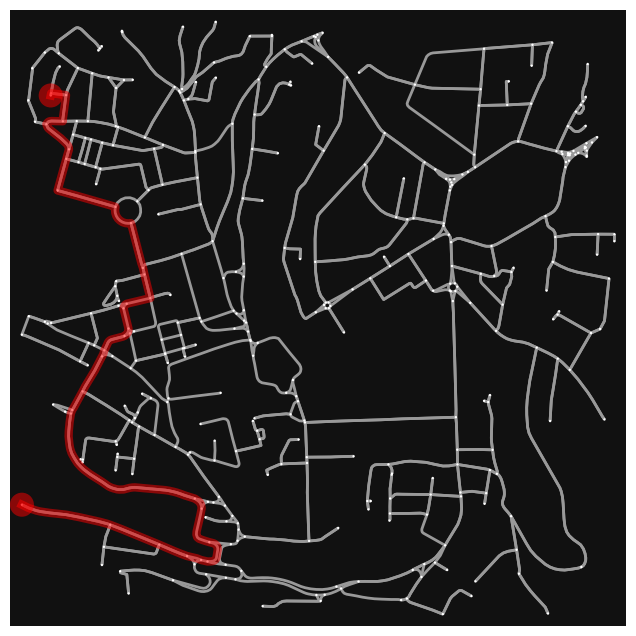

In [90]:
fig, ax = ox.plot_graph_route(G, path_osmids, route_color='red', route_linewidth=6, edge_linewidth=2, node_size=3, orig_dest_size=300)

plt.show()

**Route 3 - Driving** 

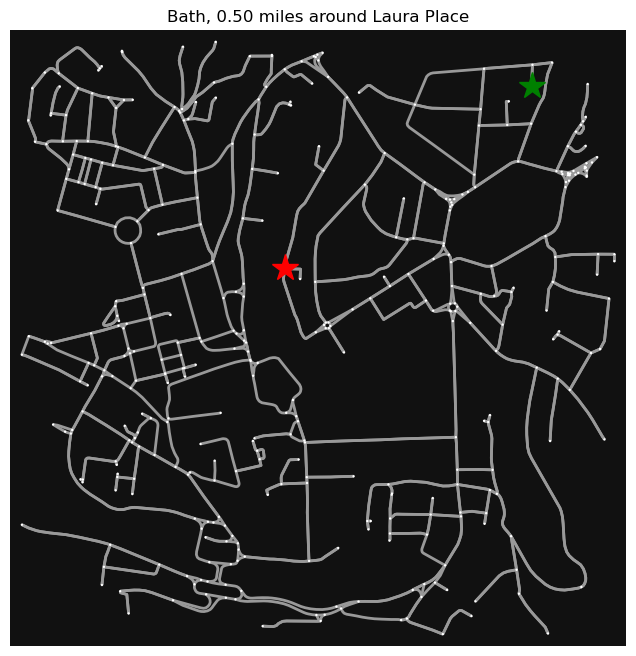

In [24]:
# Code given by Supervisor
fig, ax = ox.plot_graph(G, node_size=3, edge_linewidth=2, close=False, show=False)
#
x = gdf_nodes.x.values
y = gdf_nodes.y.values
ax.plot(x[66], y[66], "r*", ms=20, zorder=2)
ax.plot(x[167], y[167], "g*", ms=20, zorder=2)

ax.set_title(f"Bath, {miles:.2f} miles around {location}")
pass

In [25]:
start_node_index = 66
end_state_index = 167

# Emission probabilities (uniform)
b = np.full(N, 1/N) 
b[end_state_index] = 1

pi = np.zeros(N)
pi[start_node_index] = 1

In [26]:
T = 100
# Initialize the HMM class
fb = HMM_Forward_Backward()

In [27]:
best_path_indices = fb.viterbi_algorithm(A, pi, b, T, end_state_index)

In [28]:
path_osmids = gdf_nodes.iloc[best_path_indices].index.tolist()

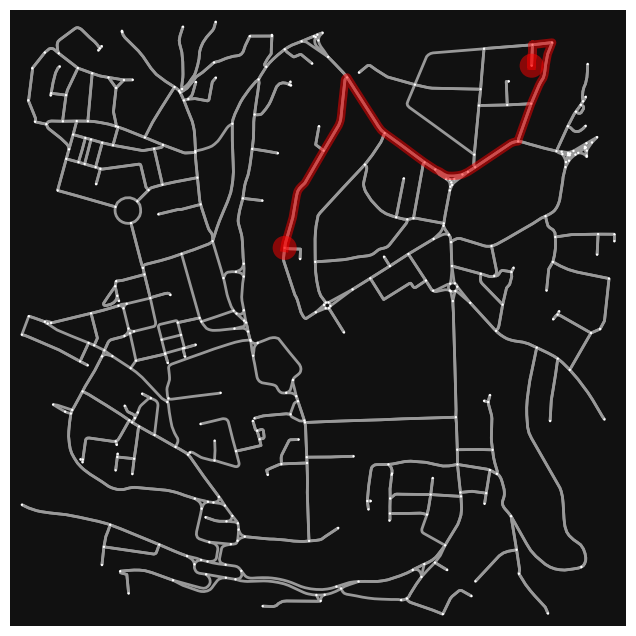

In [29]:
fig, ax = ox.plot_graph_route(G, path_osmids, route_color='red', route_linewidth=6, edge_linewidth=2, node_size=3, orig_dest_size=300)

plt.show()

**Route 1 - Biking**

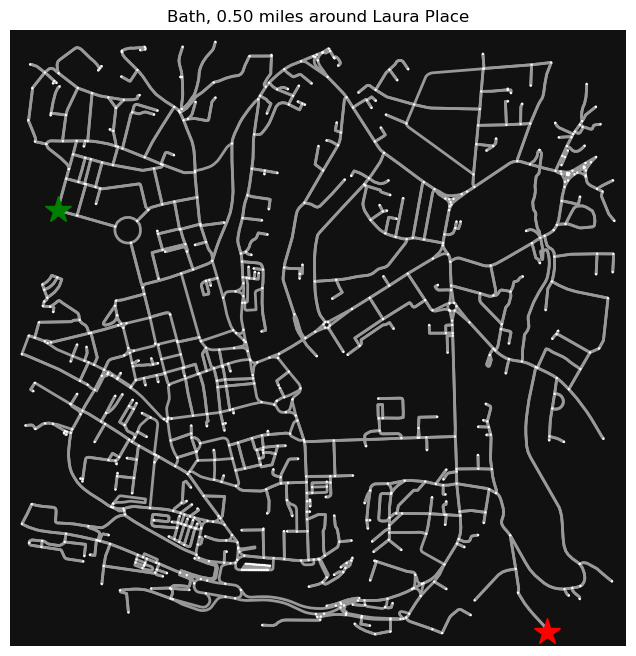

In [99]:
# Code given by Supervisor
fig, ax = ox.plot_graph(G, node_size=3, edge_linewidth=2, close=False, show=False)
#
x = gdf_nodes.x.values
y = gdf_nodes.y.values
ax.plot(x[147], y[147], "r*", ms=20, zorder=2)
ax.plot(x[151], y[151], "g*", ms=20, zorder=2)

ax.set_title(f"Bath, {miles:.2f} miles around {location}")
pass

In [93]:
start_node_index = 147
end_state_index = 151

# Emission probabilities (uniform)
b = np.full(N, 1/N) 
b[end_state_index] = 1

pi = np.zeros(N)
pi[start_node_index] = 1

In [22]:
T = 100
# Initialize the HMM class
fb = HMM_Forward_Backward()

In [95]:
best_path_indices = fb.viterbi_algorithm(A, pi, b, T, end_state_index)

In [96]:
path_osmids = gdf_nodes.iloc[best_path_indices].index.tolist()

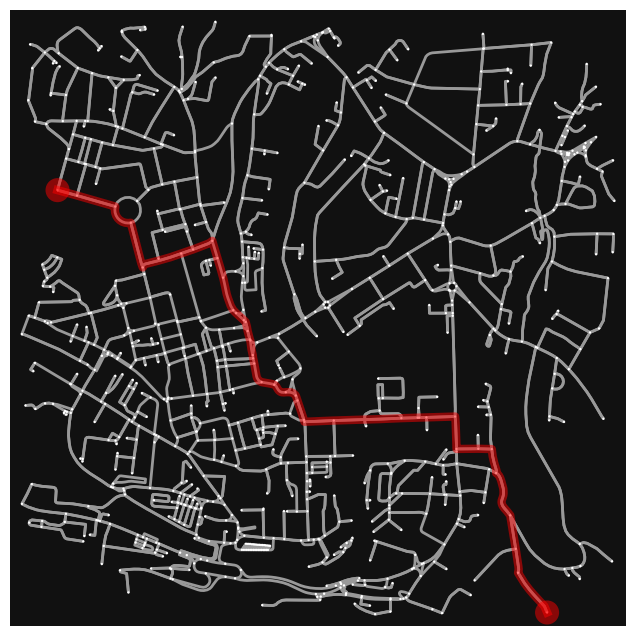

In [97]:
fig, ax = ox.plot_graph_route(G, path_osmids, route_color='red', route_linewidth=6, edge_linewidth=2, node_size=3, orig_dest_size=300)

plt.show()